In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv(r"C:\Users\Ansh Choudhary\Downloads\Sentiment AI - CNN\training.1600000.processed.noemoticon - Copy.csv", encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
data.head()
X = data.iloc[:,[5]]
Y = data.iloc[:,0]
Y[Y == 4] = 1

C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_16388\4104013209.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y[Y == 4] = 1


In [7]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
# Text-preprocessing

# Missing Values
num_missing_desc = data.isnull().sum()[2]    # No. of values with msising descriptions
print('Number of missing values: ' + str(num_missing_desc))
data = data.dropna()

TAG_CLEANING_RE = "@\S+"
# Remove @tags
X['text'] = X['text'].map(lambda x: re.sub(TAG_CLEANING_RE, ' ', x))

# Smart lowercase
X['text'] = X['text'].map(lambda x: x.lower())

# Remove numbers
X['text'] = X['text'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove links
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
X['text'] = X['text'].map(lambda x: re.sub(TEXT_CLEANING_RE, ' ', x))

# Remove Punctuation
X['text']  = X['text'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove white spaces
X['text'] = X['text'].map(lambda x: x.strip())

# Tokenize into words
X['text'] = X['text'].map(lambda x: word_tokenize(x))
 
# Remove non alphabetic tokens
X['text'] = X['text'].map(lambda x: [word for word in x if word.isalpha()])

# Filter out stop words
stop_words = set(stopwords.words('english'))
X['text'] = X['text'].map(lambda x: [w for w in x if not w in stop_words])
    
# Word Lemmatization
lem = WordNetLemmatizer()
X['text'] = X['text'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

# Turn lists back to string
X['text'] = X['text'].map(lambda x: ' '.join(x))

<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
<>:8: SyntaxWarning: invalid escape sequence '\S'
<>:19: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_16388\1675467849.py:8: SyntaxWarning: invalid escape sequence '\S'
  TAG_CLEANING_RE = "@\S+"
C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_16388\1675467849.py:19: SyntaxWarning: invalid escape sequence '\S'
  TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_16388\1675467849.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_missing_desc = data.isnull().sum()[2]    # No. of values with msising descriptions


Number of missing values: 0


In [9]:
X.head()

,text
0,zl awww bummer shoulda get david carr third day
1,upset update facebook texting might cry result...
2,dive many time ball manage save rest go bound
3,whole body feel itchy like fire
4,behave mad see


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(y_test))

TRAIN size: 1280000
TEST size: 320000


In [11]:
# WORD2VEC 
import gensim

W2V_VECTOR_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in X_train.text] 
w2v_model = gensim.models.Word2Vec(vector_size=W2V_VECTOR_SIZE, 
                                   window=W2V_WINDOW, 
                                   min_count=W2V_MIN_COUNT, 
                                   workers=8)
w2v_model.build_vocab(documents)


In [12]:
words = list(w2v_model.wv.index_to_key)
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 25276


In [13]:
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(251374398, 289225504)

In [14]:
similar_words = w2v_model.wv.most_similar("great")
print(similar_words)

[('fantastic', 0.7141191959381104), ('wonderful', 0.7093288898468018), ('good', 0.6917538046836853), ('awesome', 0.6709120273590088), ('amaze', 0.634370744228363), ('fabulous', 0.6002586483955383), ('fab', 0.5933231115341187), ('excellent', 0.5907275676727295), ('nice', 0.5710403919219971), ('enjoy', 0.5360037684440613)]


In [15]:
# Tokenizing
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
#from keras.utils.np_utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train.text)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

Found 232838 unique tokens.
Shape of data tensor: (1280000, 300)


In [16]:
# Assuming you have defined W2V_SIZE earlier in your code
W2V_SIZE = 300  # or any other value you want

# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [26]:
# Build Model
from keras.layers import Conv1D, GlobalMaxPooling1D
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.3))
model.add(Conv1D(300,3,activation='relu'))
# we use max pooling:
model.add(GlobalMaxPooling1D())
model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

C:\Users\Ansh Choudhary\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      69,851,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,851,700 (266.46 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 69,851,700 (266.46 MB)

In [23]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5, mode='max')]  # Specify mode='max' for maximizing validation accuracy

BATCH_SIZE = 512
history = model.fit(X_train_padded, y_train,
                    batch_size=512,
                    epochs=20,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks                                                                                                                                                          


Epoch 1/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10453s 5s/step - accuracy: 0.7713 - loss: 0.4732 - val_accuracy: 0.7794 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 2/20


C:\Users\Ansh Choudhary\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate
  current = self.get_monitor_value(logs)


2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10543s 5s/step - accuracy: 0.7760 - loss: 0.4664 - val_accuracy: 0.7816 - val_loss: 0.4573 - learning_rate: 0.0010
Epoch 3/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8387s 4s/step - accuracy: 0.7788 - loss: 0.4612 - val_accuracy: 0.7804 - val_loss: 0.4592 - learning_rate: 0.0010
Epoch 4/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9789s 4s/step - accuracy: 0.7816 - loss: 0.4570 - val_accuracy: 0.7829 - val_loss: 0.4548 - learning_rate: 0.0010
Epoch 5/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10977s 5s/step - accuracy: 0.7840 - loss: 0.4538 - val_accuracy: 0.7805 - val_loss: 0.4581 - learning_rate: 0.0010
Epoch 6/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8338s 4s/step - accuracy: 0.7855 - loss: 0.4509 - val_accuracy: 0.7838 - val_loss: 0.4524 - learning_rate: 0.0010
Epoch 7/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8313s 4s/step - accuracy: 0.7862 - loss: 0.4491 - val_accuracy: 0.7841 - val_loss: 0.4521 - learning_rate: 0.0010
Epoch 8/20
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8421s 4s/step - accuracy: 0.787

In [21]:
import keras
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = 'cnn_model.h5.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [27]:
model.save(r'C:\Users\Ansh Choudhary\Downloads\Sentiment AI - CNN/CNN_model.h.keras')

C:\Users\Ansh Choudhary\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_api.py:100: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


In [22]:
# Load Model
from keras.models import load_model
model = load_model("cnn_model.h5.keras")

ValueError: File not found: filepath=cnn_model.h5.keras. Please ensure the file is an accessible `.keras` zip file.

In [18]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test.text)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

NameError: name 'model' is not defined

In [25]:
# Assuming 'model' is your trained machine learning model
# Assuming 'X_train', 'y_train', 'X_val', 'y_val' are your training and validation data
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Now 'history' should be defined and accessible
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']

# You can then proceed to use 'acc', 'val_acc', and 'loss' as needed
print("ACCURACY:", acc)
print("VALIDATION ACCURACY:", val_acc)
print("LOSS:", loss)

NameError: name 'X_val' is not defined

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [ ]:
X_test_padded = tokenizer.texts_to_sequences(X_test.text)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
y_pred = model.predict(X_test_padded)

In [ ]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test, y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred_binary)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.save('C:\Users\Ansh Choudhary\Downloads\Sentiment AI - CNN')

In [19]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    if(score >=0.4 and score<=0.6):
        label = "Neutral"
    if(score <=0.4):
        label = "Negative"
    if(score >=0.6):
        label = "Positive"

    return {"label" : label,
        "score": float(score)} 

In [3]:
predict("Today is wednesday. i had a very bad day at college. my life sucks. i love my parents")

NameError: name 'pad_sequences' is not defined

In [34]:
predict("Ehsaas is happpy")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


C:\Users\Ansh Choudhary\AppData\Local\Temp\ipykernel_12012\4038234396.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Neutral', 'score': 0.43987616896629333}

In [1]:
predict("Happiness is the key to a happy life!")


NameError: name 'predict' is not defined

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 965s 96ms/step


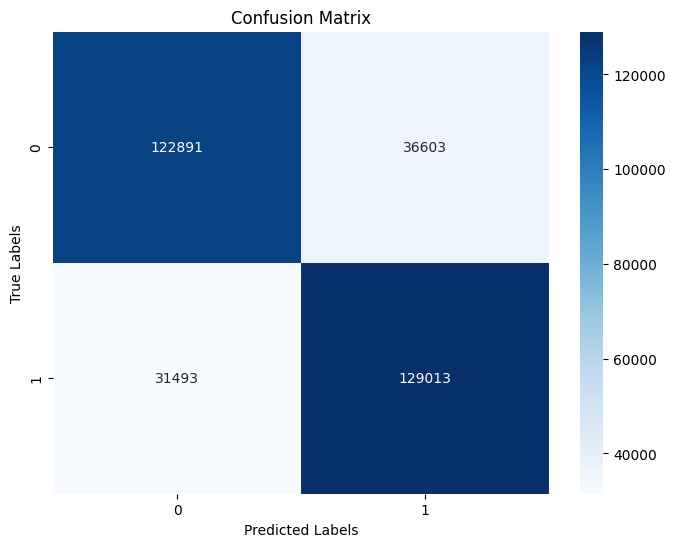

In [38]:
# Predict probabilities for each class
y_pred_prob = model.predict(X_test_padded)

# Convert probabilities to class labels
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [36]:
pip install seaborn



   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/294.9 kB 330.3 kB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 2.0 MB/s eta 0:00:01
   -------------------------------------- - 286.7/294.9 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.3 MB/s eta 0:00:00


In [12]:
pip install -U scikit-learn

     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/10.6 MB 6.3 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/10.6 MB 8.1 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/10.6 MB 6.8 MB/s eta 0:00:02
   ---- ----------------------------------- 1.1/10.6 MB 6.2 MB/s eta 0:00:02
   ----- ---------------------------------- 1.5/10.6 MB 6.7 MB/s eta 0:00:02
   ------ --------------------------------- 1.7/10.6 MB 6.3 MB/s eta 0:00:02
   ------- -------------------------------- 2.0/10.6 MB 6.7 MB/s eta 0:00:02
   -------- ------------------------------- 2.2/10.6 MB 6.4 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/10.6 MB 6.3 MB/s eta 0:00:02
   --------- ------------------------------ 2.6/10.6 MB 6.1 MB/s eta 0:00:02
   -----

In [3]:
pip install scipy==1.12

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.4 kB ? eta -:--:--
     ------------ ------------------------- 20.5/60.4 kB 131.3 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.4 kB 219.4 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.4 kB 239.5 kB/s eta 0:00:01
     -------------------------------- ----- 51.2/60.4 kB 239.5 kB/s eta 0:00:01
     -------------------------------------- 60.4/60.4 kB 200.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/45.8 MB ? eta -:--:--
   ---------------------------------------- 0.3/45.8 MB 9.9 MB/s eta 0:00:05
    --------------------------------------- 0.7/45.8 MB 8.5 MB/s eta 0:00:06
    --------------------------------------- 1.1/45.8 MB 9.0 MB/s eta 0:00:05
   - -------------------------------------- 1.3/45.8 MB 7.6 MB/s eta 0:00:06
   -

  You can safely remove it manually.
  You can safely remove it manually.


In [3]:
pip install --upgrade gensim

  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gensim: filename=gensim-4.3.2-cp312-cp312-win_amd64.whl size=23940395 sha256=c51c34a79be34071031c38950ac8c47a5f235de4950d6fae1715779919c2ab73
  Stored in directory: c:\users\ansh choudhary\appdata\local\pip\cache\wheels\50\c0\ac\7bb08954bc59d390c848b480a3fc5eec68c14bc77bf334d624
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.0
    Uninstalling gensim-3.8.0:
      Successfully uninstalled gensim-3.8.0
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install gensim

In [4]:
pip install -U pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install nltk

     ---------------------------------------- 0.0/41.9 kB ? eta -:--:--
     -------------------------------------- 41.9/41.9 kB 990.0 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 57.6/57.6 kB 1.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.5 MB 3.6 MB/s eta 0:00:01
   ---------- ----------------------------- 0.4/1.5 MB 4.7 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.5 MB 5.8 MB/s eta 0:00:01
   -------------------- ------------------- 0.8/1.5 MB 5.3 MB/s eta 0:00:01
   ------------------------------ --------- 1.1/1.5 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 6.4 MB/s eta 0:00:01
   ---------------------------------------  1.5/1.5 MB 6.4 MB/s eta 0:00:01
   ----------------

In [2]:
!pip list


Package                   Version
------------------------- ---------------
absl-py                   2.1.0
anyio                     4.2.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2023.11.17
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.0
decorator                 5.1.1
defusedxml                0.7.1
distlib                   0.3.8
executing                 2.0.1
fastjsonschema            2.19.1
filelock                  3.14.0
flatbuffers               24.3.25
fonttools   

In [9]:
pip install tensorflow

In [1]:
pip install keras

In [15]:
pip install tensorflow==2.15.0

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==2.15.0


In [14]:
pip install Keras Keras-Preprocessing requests requests-oauthlib tensorflow tweepy


   ---------------------------------------- 0.0/42.6 kB ? eta -:--:--
   ---------------------------------------- 42.6/42.6 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/98.5 kB ? eta -:--:--
   ---------------------------------------- 98.5/98.5 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/151.7 kB ? eta -:--:--
   ---------------------------------------- 151.7/151.7 kB 4.6 MB/s eta 0:00:00


In [1]:
pip install --upgrade gensim

  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
Using cached smart_open-7.0.4-py3-none-any.whl (61 kB)
Failed to build gensim
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [714 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\gensim
  copying gensim\downloader.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\interfaces.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\matutils.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\nosy.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\utils.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\__init__.py -> build\lib.win-amd64-cpython-312\gensim
  creating build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\bleicorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\csvcorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\dictionary.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  c

In [ ]:
python setup.py install

In [1]:
pip install --upgrade pip setuptools


In [3]:
pip install virtualenv


   ---------------------------------------- 0.0/3.9 MB ? eta -:--:--
   -- ------------------------------------- 0.3/3.9 MB 8.6 MB/s eta 0:00:01
   ----- ---------------------------------- 0.5/3.9 MB 6.1 MB/s eta 0:00:01
   -------- ------------------------------- 0.8/3.9 MB 6.5 MB/s eta 0:00:01
   ---------- ----------------------------- 1.0/3.9 MB 6.3 MB/s eta 0:00:01
   ------------ --------------------------- 1.3/3.9 MB 6.2 MB/s eta 0:00:01
   --------------- ------------------------ 1.5/3.9 MB 6.5 MB/s eta 0:00:01
   ----------------- ---------------------- 1.7/3.9 MB 6.4 MB/s eta 0:00:01
   --------------------- ------------------ 2.1/3.9 MB 6.2 MB/s eta 0:00:01
   -------------------------- ------------- 2.6/3.9 MB 6.6 MB/s eta 0:00:01
   ----------------------------- ---------- 2.9/3.9 MB 6.6 MB/s eta 0:00:01
   -------------------------------- ------- 3.2/3.9 MB 6.5 MB/s eta 0:00:01
   ----------------------------------- ---- 3.5/3.9 MB 6.5 MB/s eta 0:00:01
   ---------------

In [6]:
pip install gensim

  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
Using cached smart_open-7.0.4-py3-none-any.whl (61 kB)
Failed to build gensim
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [714 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\gensim
  copying gensim\downloader.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\interfaces.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\matutils.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\nosy.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\utils.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\__init__.py -> build\lib.win-amd64-cpython-312\gensim
  creating build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\bleicorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\csvcorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\dictionary.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  c

In [8]:
!pip list


Package                   Version
------------------------- ---------------
absl-py                   2.1.0
anyio                     4.2.0
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
astunparse                1.6.3
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
beautifulsoup4            4.12.3
bleach                    6.1.0
certifi                   2023.11.17
cffi                      1.16.0
charset-normalizer        3.3.2
click                     8.1.7
colorama                  0.4.6
comm                      0.2.1
contourpy                 1.2.1
cycler                    0.12.1
debugpy                   1.8.0
decorator                 5.1.1
defusedxml                0.7.1
distlib                   0.3.8
executing                 2.0.1
fastjsonschema            2.19.1
filelock                  3.14.0
flatbuffers               24.3.25
fonttools   

In [9]:
!pip install gensim


  Using cached gensim-4.3.2.tar.gz (23.3 MB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached smart_open-7.0.4-py3-none-any.whl.metadata (23 kB)
Using cached smart_open-7.0.4-py3-none-any.whl (61 kB)
Failed to build gensim


  error: subprocess-exited-with-error
  
  exit code: 1
  
  [714 lines of output]
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-312
  creating build\lib.win-amd64-cpython-312\gensim
  copying gensim\downloader.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\interfaces.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\matutils.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\nosy.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\utils.py -> build\lib.win-amd64-cpython-312\gensim
  copying gensim\__init__.py -> build\lib.win-amd64-cpython-312\gensim
  creating build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\bleicorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\csvcorpus.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  copying gensim\corpora\dictionary.py -> build\lib.win-amd64-cpython-312\gensim\corpora
  c